In [1]:
# default_exp modeling.multi_frame_model

In [2]:
#export
from dfdc.modeling.dataset_utils import *
from fastai.vision import *

In [3]:
data_path = Path("/home/ubuntu/data/dfdc"); data_path.ls()

[PosixPath('/home/ubuntu/data/dfdc/dfdc_face_detections'),
 PosixPath('/home/ubuntu/data/dfdc/dfdc_cropped_faces'),
 PosixPath('/home/ubuntu/data/dfdc/dfdc_training_csv'),
 PosixPath('/home/ubuntu/data/dfdc/cookies.txt'),
 PosixPath('/home/ubuntu/data/dfdc/dfdc_train')]

In [4]:
cropped_path = data_path/'dfdc_cropped_faces'; print(cropped_path)

/home/ubuntu/data/dfdc/dfdc_cropped_faces


In [5]:
training_csv_path = data_path/'dfdc_training_csv'; print(training_csv_path)

/home/ubuntu/data/dfdc/dfdc_training_csv


### Train-Valid-Test DataFrames

In [6]:
train_parts = list(range(40))
valid_parts = list(range(40,45))
test_parts = list(range(45,50))

In [7]:
len(train_parts), len(test_parts), len(test_parts)

(40, 5, 5)

In [8]:
def read_train_csv(fname):
    df = pd.read_csv(fname, usecols=['fname', 'label', 'original', 'source', 'face_crop_fnames'])
    df['face_crop_fnames'] = df['face_crop_fnames'].apply(eval)
    return df

In [9]:
train_dfs = [read_train_csv(training_csv_path/f'part_{part_no}_training.csv') for part_no in train_parts]
valid_dfs = [read_train_csv(training_csv_path/f'part_{part_no}_training.csv' )for part_no in valid_parts]
test_dfs = [read_train_csv(training_csv_path/f'part_{part_no}_training.csv') for part_no in test_parts]

In [10]:
train_df = pd.concat(train_dfs).reset_index(drop=True)
valid_df = pd.concat(valid_dfs).reset_index(drop=True)
test_df = pd.concat(test_dfs).reset_index(drop=True)

In [11]:
train_df.shape, valid_df.shape, test_df.shape

((92724, 5), (12111, 5), (12367, 5))

In [12]:
len(train_df.fname.unique()), len(valid_df.fname.unique()), len(test_df.fname.unique())

(92724, 12111, 12367)

In [13]:
train_df.head(4)

,fname,label,original,source,face_crop_fnames
0,owxbbpjpch.mp4,FAKE,wynotylpnm.mp4,wynotylpnm.mp4,"[dfdc_train_part_0/owxbbpjpch/frame_1_30.jpg, ..."
1,bpguesjrfa.mp4,FAKE,wynotylpnm.mp4,wynotylpnm.mp4,"[dfdc_train_part_0/bpguesjrfa/frame_1_30.jpg, ..."
2,skewcclbhg.mp4,FAKE,wynotylpnm.mp4,wynotylpnm.mp4,"[dfdc_train_part_0/skewcclbhg/frame_1_30.jpg, ..."
3,ybdtkypwez.mp4,FAKE,wynotylpnm.mp4,wynotylpnm.mp4,"[dfdc_train_part_0/ybdtkypwez/frame_1_30.jpg, ..."


In [14]:
def flatten_df(df):
    flat_res = []
    for _, row in df.iterrows():
        fname = row['fname']
        for crop_fname in row['face_crop_fnames']:
            flat_res.append({"fname":fname, "crop_fname":crop_fname, "label":row['label']})
    df = pd.DataFrame(flat_res)
    df.label = df.label.map({"FAKE":1, "REAL":0})
    return df

In [15]:
def create_source2fakes(df):
    source2fakes = defaultdict(list)
    for _, row in df.iterrows():
        if row['source'] != row['fname']:
            source2fakes[row['source']].append(row['fname'])
    return source2fakes

In [16]:
class temporary_seed:
    def __init__(self, seed):
        self.seed = seed
        self.backup = None

    def __enter__(self):
        self.backup = np.random.randint(2**32-1, dtype=np.uint32)
        np.random.seed(self.seed)

    def __exit__(self, *_):
        np.random.seed(self.backup)

In [17]:
source2fakes = create_source2fakes(valid_df)

In [18]:
with temporary_seed(42):
    sourceslist = list(source2fakes.keys())
    fakeslist = list(np.random.choice(v) for k,v in source2fakes.items())
    subfnames = np.concatenate([sourceslist, fakeslist])
    balanced_valid_df = valid_df[valid_df.fname.isin(subfnames)].reset_index(drop=True)

In [19]:
balanced_valid_df.head(4)

,fname,label,original,source,face_crop_fnames
0,vpkqjedfnn.mp4,FAKE,tkygmnaifp.mp4,tkygmnaifp.mp4,"[dfdc_train_part_40/vpkqjedfnn/frame_1_30.jpg,..."
1,tkygmnaifp.mp4,REAL,NaN,tkygmnaifp.mp4,"[dfdc_train_part_40/tkygmnaifp/frame_1_30.jpg,..."
2,qyehiscxbr.mp4,REAL,NaN,qyehiscxbr.mp4,"[dfdc_train_part_40/qyehiscxbr/frame_1_30.jpg,..."
3,ckhiqguxzt.mp4,FAKE,qyehiscxbr.mp4,qyehiscxbr.mp4,"[dfdc_train_part_40/ckhiqguxzt/frame_1_30.jpg,..."


### Transforms

In [20]:
from fastai.vision import transform 

In [21]:
def crappify(pilimg):
    pilimg = pilimg.resize((64,64))
    pilimg = pilimg.resize((224,224))
    return pilimg

In [22]:
def get_tfms_dict(crappify_thresh=0.25, fliplr_thresh=0.25, brightness_thresh=0.25, zoom_thresh=0.25):
    "crappify to low res, flip left-right, change brightness"
    # crappify 
    crappify_p = np.random.uniform(); do_crappify = crappify_p < crappify_thresh
    # fliplr 
    fliplr_p = np.random.uniform(); do_fliplr = fliplr_p < fliplr_thresh
    # change brightness 
    brightness_p = np.random.uniform(); do_brightness = brightness_p < brightness_thresh
    # zoom
    zoom_p = np.random.uniform(); do_zoom = zoom_p < zoom_thresh
    
    if do_brightness: brightness_change = np.random.uniform(0.2,0.8)
    else: brightness_change = None
    if do_zoom: zoom_scale = np.random.uniform(1.15,1.35)
    else: zoom_scale = None
        
    tfms_dict = {"crappify": do_crappify, 
                 "fliplr": do_fliplr, 
                 "brightness": (do_brightness, brightness_change),
                 "zoom": (do_zoom, zoom_scale)}
    return tfms_dict

In [23]:
tfms_dict = get_tfms_dict(1,1,1,1); tfms_dict

{'crappify': True,
 'fliplr': True,
 'brightness': (True, 0.7606108710147046),
 'zoom': (True, 1.3193468958581192)}

1.0389918549828923


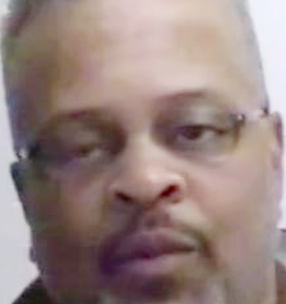

In [24]:
img = open_image(cropped_path/balanced_valid_df['face_crop_fnames'][0][0])
zoom_scale = np.random.uniform(1,1.4); print(zoom_scale)
if tfms_dict['fliplr']: img = flip_lr(img) 
if tfms_dict['brightness'][0]: img = brightness(img, tfms_dict['brightness'][1])
if tfms_dict['zoom'][0]: img = zoom(img, tfms_dict['zoom'][1])
img

In [25]:
get_tfms_dict(0.25, 0.25, 0.25, 0.25)

{'crappify': False,
 'fliplr': False,
 'brightness': (False, None),
 'zoom': (False, None)}

### Multi Frame 1 Fake Batch Sampler

- Permutate original videos
- Pick a random fake for each original video
- Pick up to 30 frames for both original video and selected fake 
- Original and it's fake should be in same batch - Consistency Loss for focusing on alteration areas

#### Single Real Fake Sampler

In [26]:
class MultiFrameRealFakeSampler(Sampler):
    "Sample single random fake for each source with same single crop frame"
    def __init__(self, train_df):
        
        self.train_df = train_df
        self.unique_originals = np.unique((self.train_df.original).dropna())
        # get fname indexes for sampling
        self.fname2idx = {k:v for v,k in enumerate(self.train_df['fname'])} 
        # get source:fakes mapping 
        self.source2fakes = create_source2fakes(train_df)        
        for k,v in self.source2fakes.items(): assert len(v) > 0
        # convert face crop fnames to array
        self.face_crop_fnames = self.train_df['face_crop_fnames'].values
        
        
    def __iter__(self):
        # shuffle original videos
        unique_originals = np.random.permutation(self.unique_originals)
        
        # collect indexes for source and fake
        all_idxs = []
        for source in unique_originals: 
            fake = np.random.choice(self.source2fakes[source])
            source_fname_idx = self.fname2idx[source]
            fake_fname_idx = self.fname2idx[fake]
            
            # pick a random frame for real and fake
            num_frames = len(self.face_crop_fnames[source_fname_idx])
            
            # real video, fake video, random frame
            all_idxs.append((source_fname_idx, fake_fname_idx))
        
        return iter(all_idxs)
    
    def __len__(self):
        return len(self.unique_originals)*2

#### BatchSampler

In [27]:
class MultiFrameRealFakeBatchSampler(Sampler):
    "Batch real and fake pairs from sampler with same tfms"
    def __init__(self, sampler, batch_size, drop_last, tfms=True):
        self.sampler = sampler
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.tfms = tfms

    def __iter__(self):
        batch = []
        for real_idx, fake_idx in self.sampler:
            # get tfms dict for augmentation
            if self.tfms: tfms_dict = get_tfms_dict(0.25, 0.25, 0.25, 0.25)
            else: tfms_dict = None
            batch.append((real_idx, tfms_dict))
            batch.append((fake_idx, tfms_dict))
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0 and not self.drop_last:
            yield batch

    def __len__(self):
        if self.drop_last:
            return len(self.sampler) // self.batch_size
        else:
            return (len(self.sampler) + self.batch_size - 1) // self.batch_size

#### Dataset

In [28]:
max_seq_len = 15

In [29]:
def open_pilimg(crop_fname):
    return (PIL.Image.open(cropped_path/crop_fname)
                      .convert('RGB')
                      .resize((224,224)))

def transform_pilimg(pilimg, tfms_dict):
    if tfms_dict is not None:
        if tfms_dict['crappify']: pilimg = crappify(pilimg)
        img = Image(pil2tensor(pilimg, np.float32).div(255))
        if tfms_dict['fliplr']: img = flip_lr(img) 
        if tfms_dict['brightness'][0]: img = brightness(img, tfms_dict['brightness'][1])
        if tfms_dict['zoom'][0]: img = zoom(img, tfms_dict['zoom'][1])
        img = img.data
    else: 
        img = pil2tensor(pilimg, np.float32).div(255)
    return img
        

class MultiFrameRealFakeDataset(Dataset):
    def __init__(self, cropped_path, df, sampler):
        self.sampler = sampler
        self.cropped_path = cropped_path
        self.df = df
        self.face_crop_fnames = df['face_crop_fnames'].values
        self.labels = df['label'].map({"REAL":0, "FAKE":1}).values
        self.max_seq_len = max_seq_len
        
        
    def __getitem__(self, idxs:Tuple):
        fname_idx, tfms_dict = idxs
        # read
        crop_fnames = self.face_crop_fnames[fname_idx][:self.max_seq_len]
        pilimgs = [open_pilimg(o) for o in crop_fnames]
        # transform
        imgs = [transform_pilimg(o, tfms_dict) for o in pilimgs]
        # normalize
        imgs = [normalize(img, *[tensor(o) for o in imagenet_stats]) for img in imgs]
        img = torch.stack(imgs)
        
        seq_len = img.size(0)
        label = self.labels[fname_idx]
        return img, (seq_len, label)
    
    def __len__(self): return len(self.sampler)

In [30]:
def pad_collate(batch): 
    imgs, seq_lens, labels = [], [], []
    for b in batch:
        img, (seq_len, label) = b
        n_pad = max_seq_len - seq_len
        if n_pad > 0: 
            img = torch.cat([img, torch.zeros(n_pad,3,224,224)])
        imgs.append(img)
        seq_lens.append(seq_len)
        labels.append(label)
    return (tensor(seq_lens).long(), torch.cat(imgs)),  tensor(labels).long()

#### Validation Samplers

In [31]:
class MultiFrameValidSampler(Sampler):
    "sample all frames for each given video in df"
    def __init__(self, valid_df):
        valid_idxs = []
        valid_face_crop_fnames = valid_df.face_crop_fnames.values
        for i, l in enumerate(valid_face_crop_fnames): valid_idxs.append((i,None))
        self.valid_idxs = valid_idxs
        
    def __iter__(self): return iter(self.valid_idxs)
    def __len__(self): return len(self.valid_idxs)

### Create Train Dataloader

In [32]:
bs = 32

In [33]:
_mean, _std = tensor(imagenet_stats[0]), tensor(imagenet_stats[1])

In [34]:
train_sampler = MultiFrameRealFakeSampler(train_df) # 1 real 1 fake
batch_sampler = MultiFrameRealFakeBatchSampler(train_sampler, 
                                                batch_size=bs,
                                                drop_last=False, 
                                                tfms=True) # 1 real 1 fake 

train_ds = MultiFrameRealFakeDataset(cropped_path, train_df, train_sampler)
train_dl = DataLoader(train_ds, batch_sampler=batch_sampler, collate_fn=pad_collate, num_workers=defaults.cpus)

In [35]:
# (seq_lens, xb), yb = next(iter(train_dl))

In [36]:
def denorm_tensor(t): return (t*_std[...,None, None] + _mean[...,None,None])

In [37]:
# seq_lens = torch.repeat_interleave(seq_lens, max_seq_len)
# labels = torch.repeat_interleave(yb, max_seq_len)

In [38]:
# xb.shape, seq_lens.shape, labels.shape

In [39]:
# n = 15
# axes = subplots(n,n).flatten()
# for ax, t, l in zip(axes, xb[:n**2], labels[:n**2]):
#     im = Image(denorm_tensor(t))
#     im.show(ax=ax, title=l.item())

### Create Valid Dataloader

In [40]:
valid_sampler = MultiFrameValidSampler(balanced_valid_df)
valid_ds = MultiFrameRealFakeDataset(cropped_path, balanced_valid_df, valid_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler, collate_fn=pad_collate, num_workers=defaults.cpus)

In [41]:
# (seq_lens, xb), yb = next(iter(valid_dl))

In [42]:
# seq_lens = torch.repeat_interleave(seq_lens, max_seq_len)
# labels = torch.repeat_interleave(yb, max_seq_len)

In [43]:
# xb.shape, seq_lens.shape, labels.shape

In [44]:
# seq_lens

In [45]:
# n = 15
# axes = subplots(n,n).flatten()
# for ax, t, l in zip(axes, xb[:n**2], labels[:n**2]):
#     im = Image(denorm_tensor(t))
#     im.show(ax=ax, title=l.item())

In [46]:
# del xb, yb
# gc.collect()

### CRNN Model

- 1) Unidirectional last hidden state model
- 2) Bidirectional average of all hidden state model
- 3) Bidirectional attention based weighted average of all hidden state model

In [47]:
from fastai.callbacks import *
from torch.nn.utils.rnn import pack_padded_sequence
# from fastai.vision.models.cadene_models import *
# from fastai.vision.models.efficientnet import *

Create learner with random validation

In [48]:
data = DataBunch(train_dl, valid_dl, collate_fn=pad_collate); data.c = 2

In [49]:
(seq_lens, xb), yb = data.one_batch()

In [50]:
xb.shape, seq_lens, yb

(torch.Size([480, 3, 224, 224]),
 tensor([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
         15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]),
 tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
         0, 1, 0, 1, 0, 1, 0, 1]))

In [51]:
del xb, yb, seq_lens; gc.collect()

40

In [52]:
# labels = torch.repeat_interleave(yb, max_seq_len)
# xb = to_cpu(xb)
# n = 15
# axes = subplots(n,n).flatten()
# for ax, t, l in zip(axes, xb[:n**2], labels[:n**2]):
#     im = Image(denorm_tensor(t))
#     im.show(ax=ax, title=l.item())

In [53]:
class PoolFlatten(Module):
    def __init__(self):
        self.pool = AdaptiveConcatPool2d()
        self.flatten = Flatten()
    def forward(self,x): return self.flatten(self.pool(x))
# pool_flatten = PoolFlatten()

In [54]:
# model_fn = models.resnet34
# learner = cnn_learner(data, model_fn, ps=0.7)
# learner.load("single_frame_final_resnet34")
# learner.model
# cnn = learner.model[:-1].eval()
# del learner; gc.collect()

In [55]:
# cnn_out = pool_flatten(cnn(xb.cuda()))
# cnn_out = cnn_out.view(-1, max_seq_len, 1024).contiguous()
# cnn_out.shape

In [56]:
# packed_x = pack_padded_sequence(cnn_out, seq_lens, batch_first=True, enforce_sorted=False)
# packed_x.data.shape

In [57]:
# input_size, hidden_size, bidirectional, num_layers, p = 1024, 256, True, 2, 0
# lstm = nn.LSTM(input_size=input_size, 
#                        hidden_size=hidden_size, 
#                        bidirectional=bidirectional,
#                        num_layers=num_layers, 
#                        dropout=p,
#                        batch_first=True).cuda()

In [58]:
# cnn_out.shape

In [59]:
# reduced_mean_x = []
# for i in range(len(seq_lens)):
#     output, (h_n, c_n) = lstm(cnn_out[i][:seq_lens[i]][None,...])
#     reduced_mean_x.append(output[0].mean(0))
# reduced_mean_x = torch.stack(reduced_mean_x)

In [60]:
# reduced_mean_x.shape

In [61]:
class LSTM(Module):
    def __init__(self, input_size=1024, hidden_size=512, bidirectional=False, num_layers=2, p=0.5):
        
        self.lstm = nn.LSTM(input_size=input_size, 
                       hidden_size=hidden_size, 
                       bidirectional=bidirectional,
                       num_layers=num_layers, 
                       dropout=p if num_layers>1 else 0,
                       batch_first=True)
        
        
    def forward(self, seq_lens, cnn_out):
        reduced_mean_x = []
        for i in range(len(seq_lens)):
            output, (h_n, c_n) = self.lstm(cnn_out[i][:seq_lens[i]][None,...])
            reduced_mean_x.append(output[0].mean(0))
        reduced_mean_x = torch.stack(reduced_mean_x)
        
        return reduced_mean_x

In [62]:
class Linear(Module):
    def __init__(self, hidden_size, bidirectional, p=0.5, use_bn=True):        
        n_if = hidden_size*2 if bidirectional else hidden_size
        self.bn1 = nn.BatchNorm1d(n_if)
        self.dp1 = nn.Dropout(p)
        self.lin1 = nn.Linear(n_if, 2, bias=False)
        if use_bn: self.fc = nn.Sequential(self.bn1, self.dp1, self.lin1)
        else: self.fc = nn.Sequential(self.dp1, self.lin1)

    def forward(self, x): return self.fc(x)

In [63]:
class CRNNModel(Module):
    def __init__(self, cnn, lstm, fc):
        self.cnn = cnn
        self.pool_flatten = PoolFlatten()
        self.lstm = lstm
        self.fc = fc
        
    def forward(self, seq_lens, xb):
        cnn_out = self.pool_flatten(self.cnn(xb))
        cnn_out = cnn_out.view(-1, max_seq_len, 1024).contiguous()
        lstm_out = self.lstm(seq_lens, cnn_out)
        return self.fc(lstm_out)

In [64]:
# lstm = LSTM(input_size=1024, hidden_size=512, bidirectional=True, num_layers=2, p=0.5)
# fc = Linear(hidden_size=512, bidirectional=True, p=0.5, use_bn=True)
# crnn_model = CRNNModel(cnn, lstm, fc).cuda()
# crnn_model(seq_lens, xb.cuda()).softmax(1)

### Training

In [66]:
model_fn = models.resnet34
learner = cnn_learner(data, model_fn, ps=0.7)
learner.load("single_frame_final_resnet34")
cnn = learner.model[:-1]
del learner; gc.collect()

0

In [67]:
lstm = LSTM(input_size=1024, hidden_size=512, bidirectional=True, num_layers=2, p=0.8)
fc = Linear(hidden_size=512, bidirectional=True, p=0.8, use_bn=True)
crnn_model = CRNNModel(cnn, lstm, fc)

In [68]:
learner = Learner(data, crnn_model)
learner.to_fp16()
learner.loss_func = CrossEntropyFlat()
learner.metrics = [accuracy]
def crnn_split(m): return (m.cnn[0][6], m.lstm)
learner.split(crnn_split)
learner.freeze_to(2);

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


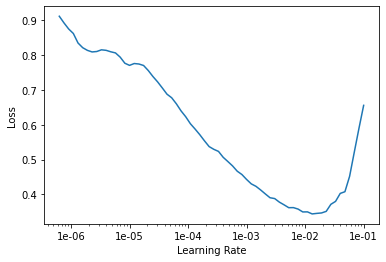

In [69]:
learner.lr_find()
learner.recorder.plot()

In [71]:
early_stop_cb = EarlyStoppingCallback(learner,
                                      monitor='valid_loss',
                                      mode='min',
                                      patience=10)
save_model_cb = SaveModelCallback(learner,
                                  every='improvement', 
                                  monitor='valid_loss',
                                  name='multi_frame_resnet_lstm')

In [ ]:
lr=5e-3
learner.fit_one_cycle(10, slice(lr), callbacks=[early_stop_cb, save_model_cb])

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learner.freeze_to(1)
learner.fit_one_cycle(10, slice(lr/3), callbacks=[early_stop_cb, save_model_cb])

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(10, slice(lr/9), callbacks=[early_stop_cb, save_model_cb])

In [76]:
learner.validate()

[0.2899297, tensor(0.9045)]

In [77]:
learner.save_model_callback.name

'multi_frame_resnet_lstm'

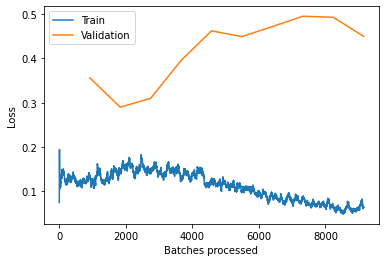

In [79]:
learner.recorder.plot_losses()

### validate

In [55]:
learner.load('single_frame_final_inception');
learner.to_fp32();

In [56]:
learner.data.valid_ds.sampler

In [57]:
preds, targs = learner.get_preds()

In [70]:
valid_flat_df = flatten_df(valid_df)
assert all((valid_flat_df['label']).values == to_np(targs))

In [109]:
preds0 = to_np(preds)[:,0]
preds1 = to_np(preds)[:,1]
targs_np = to_np(targs)

In [142]:
F.binary_cross_entropy(tensor(preds1), targs.float())

tensor(0.2731)

In [93]:
valid_flat_df['preds'] = preds1

In [189]:
mean_df = valid_flat_df.groupby("fname")[['label', 'preds']].mean()

In [190]:
mean_df = mean_df.reset_index()

In [155]:
def create_source2fakes(df):
    source2fakes = defaultdict(list)
    for _, row in df.iterrows():
        if row['source'] != row['fname']:
            source2fakes[row['source']].append(row['fname'])
    return source2fakes

In [156]:
source2fakes = create_source2fakes(valid_df)

In [197]:
sourceslist = list(source2fakes.keys())
fakeslist = list(np.random.choice(v) for k,v in source2fakes.items())
subfnames = np.concatenate([sourceslist, fakeslist])
submean_df = mean_df[mean_df.fname.isin(subfnames)]

In [198]:
mean_preds1 = tensor(submean_df['preds'].values)
mean_targs = tensor(submean_df['label'].values)

In [199]:
F.binary_cross_entropy(tensor(mean_preds1), mean_targs.float())

tensor(0.2577)

### test

In [104]:
test_sampler = SingleFrameValidSampler(test_df)
test_ds = SingleFrameRealFakeDataset(cropped_path, test_df, test_sampler)

In [105]:
test_dl = DeviceDataLoader(DataLoader(test_ds, 128, sampler=test_sampler, num_workers=defaults.cpus),
                           device=defaults.device)
learner.data.valid_dl = test_dl

In [106]:
metric = MeanValidLoss(test_df)
learner.metrics = [metric]

In [109]:
learner.to_fp16();
learner.validate()

[0.2791183, tensor(0.1625)]


### analyze preds

In [110]:
preds, targs = learner.get_preds()

In [126]:
preds.shape, targs.shape

(torch.Size([346373, 2]), torch.Size([346373]))

In [127]:
targs

tensor([1, 1, 1,  ..., 0, 0, 0])

In [128]:
preds

tensor([[3.4002e-05, 9.9997e-01],
        [2.2212e-05, 9.9998e-01],
        [1.8559e-05, 9.9998e-01],
        ...,
        [9.6729e-01, 3.2713e-02],
        [9.9847e-01, 1.5307e-03],
        [9.9938e-01, 6.2268e-04]])

In [129]:
test_flat_df = flatten_df(test_df)

In [130]:
test_flat_df['preds'] = to_np(preds[:,1])

In [131]:
rand_fname = np.random.choice(test_flat_df.fname.unique())
subdf = test_flat_df[test_flat_df.fname == rand_fname].reset_index(drop=True)
subpreds = subdf['preds'].values

In [132]:
subdf['label'].unique(), min(subpreds), max(subpreds), np.mean(subpreds)

(array([1]), 0.005576545, 0.9999962, 0.9667486)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 29.]),
 array([0.005577, 0.105019, 0.20446 , 0.303902, 0.403344, 0.502786, 0.602228, 0.70167 , 0.801112, 0.900554, 0.999996],
       dtype=float32),
 <a list of 10 Patch objects>)

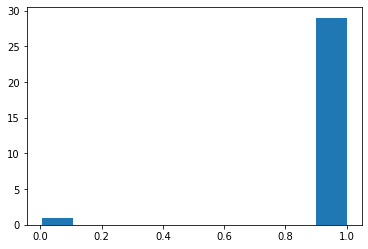

In [133]:
plt.hist(subdf['preds'])

In [134]:
meandf = test_flat_df.groupby("fname").mean()

In [135]:
min(meandf['preds']), max(meandf['preds'])

(4.1724074861804183e-08, 0.9999969005584717)

In [136]:
bestscore = 1
for clipval in np.arange(0.001, 0.2, 0.001):
    mean_labels = meandf['label'].values
    mean_preds = meandf['preds'].values
    mean_preds = np.clip(mean_preds, clipval, 1-clipval)
    score = - np.mean(np.concatenate([mean_labels*np.log(mean_preds), (1-mean_labels)*np.log(1-mean_preds)]))
    if score < bestscore:
        bestscore = score
        bestval = clipval

In [137]:
bestscore, bestval

(0.07985394583093856, 0.006)

### confusion matrix & accuracy

In [138]:
from sklearn.metrics import confusion_matrix

In [139]:
confusion_matrix(meandf['label'].values, (meandf['preds'] > 0.5).values)

array([[1764,  395],
       [ 308, 9900]])

In [140]:
np.mean(meandf['label'].values == (meandf['preds'] > 0.5).values)

0.9431551710196491

### visualize false n/p

In [148]:
min(meandf['preds']), max(meandf['preds'])

(2.00074623535329e-10, 0.9999976754188538)

In [158]:
logloss = -(meandf['label']*np.log(np.clip(meandf['preds'], 0.01, 0.99))
      + (1 - meandf['label'])*np.log(1 - np.clip(meandf['preds'], 0.01, 0.99)))

In [165]:
test_df['preds'] =test_df['fname'].map(meandf['preds'])
test_df['logloss'] = test_df['fname'].map(logloss)

In [169]:
sorted_test_df = test_df.sort_values('logloss', ascending=False).reset_index(drop=True)

In [173]:
sorted_test_df.head(10)

,fname,label,original,source,face_crop_fnames,preds,logloss
0,eswzqomvye.mp4,REAL,NaN,eswzqomvye.mp4,"[dfdc_train_part_48/eswzqomvye/frame_1_30.jpg,...",0.993195,4.605171
1,dwkmwwyvpj.mp4,REAL,NaN,dwkmwwyvpj.mp4,"[dfdc_train_part_45/dwkmwwyvpj/frame_1_30.jpg,...",0.999852,4.605171
2,uvzlfuxalu.mp4,REAL,NaN,uvzlfuxalu.mp4,"[dfdc_train_part_45/uvzlfuxalu/frame_1_30.jpg,...",0.999770,4.605171
3,vibhrvveql.mp4,REAL,NaN,vibhrvveql.mp4,"[dfdc_train_part_45/vibhrvveql/frame_1_30.jpg,...",0.999224,4.605171
4,xiwpvcxuhr.mp4,REAL,NaN,xiwpvcxuhr.mp4,"[dfdc_train_part_48/xiwpvcxuhr/frame_1_31.jpg,...",0.991617,4.605171
5,armthxafvt.mp4,REAL,NaN,armthxafvt.mp4,"[dfdc_train_part_45/armthxafvt/frame_1_30.jpg,...",0.999875,4.605171
6,icjdgqaegf.mp4,REAL,NaN,icjdgqaegf.mp4,"[dfdc_train_part_45/icjdgqaegf/frame_1_30.jpg,...",0.999872,4.605171
7,hwsgjnslze.mp4,REAL,NaN,hwsgjnslze.mp4,"[dfdc_train_part_48/hwsgjnslze/frame_1_31.jpg,...",0.996124,4.605171
8,skipjcgjjv.mp4,REAL,NaN,skipjcgjjv.mp4,"[dfdc_train_part_45/skipjcgjjv/frame_1_30.jpg,...",0.999810,4.605171
9,pxstpntfik.mp4,REAL,NaN,pxstpntfik.mp4,"[dfdc_train_part_45/pxstpntfik/frame_1_30.jpg,...",0.999885,4.605171


<BarContainer object of 12367 artists>

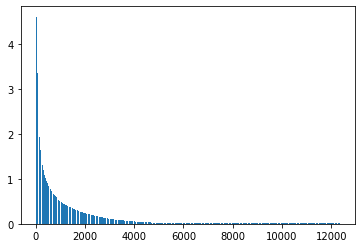

In [254]:
plt.bar(range(len(sorted_test_df['logloss'])), sorted_test_df['logloss'])

In [188]:
rows = iter(sorted_test_df.iterrows())

In [294]:
_, row = next(rows); row

fname                                                  iofnzcsfzb.mp4
label                                                            FAKE
original                                               wsdaezrogo.mp4
source                                                 wsdaezrogo.mp4
face_crop_fnames    [dfdc_train_part_49/iofnzcsfzb/frame_1_30.jpg,...
preds                                                       0.0164949
logloss                                                        4.1047
Name: 47, dtype: object

In [ ]:
n = int(np.ceil(np.sqrt(len(row['face_crop_fnames']))))
for crop_fname, ax in  zip(row['face_crop_fnames'], subplots(n,n).flatten()):
    img = open_image(cropped_path/crop_fname)
    img.show(ax=ax)

### Grad CAM

In [228]:
m = learner.to_fp32().model.eval()

In [ ]:
xb, yb = next(iter(train_dl))

In [229]:
def show_gradcam(m:Module, x:Tensor, y:Tensor, heatmap_thresh = 16, ax=None):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(x[None, ...].cuda())
            preds[0,y].backward()

    acts  = hook_a.stored[0].cpu() #activation maps
    if (acts.shape[-1]*acts.shape[-2]) >= heatmap_thresh:
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = F.relu(((acts*grad_chan[...,None,None])).sum(0))

    xb_im = Image(denorm_tensor(x))
    if ax is None: _,ax = plt.subplots()
    sz = list(xb_im.shape[-2:])
    prob = np.round(to_np(preds.softmax(1)[0,y]), 3)
    xb_im.show(ax, title=f"pred proba: {prob} gt: {y.item()}")
    ax.imshow(mult, alpha=0.4, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')

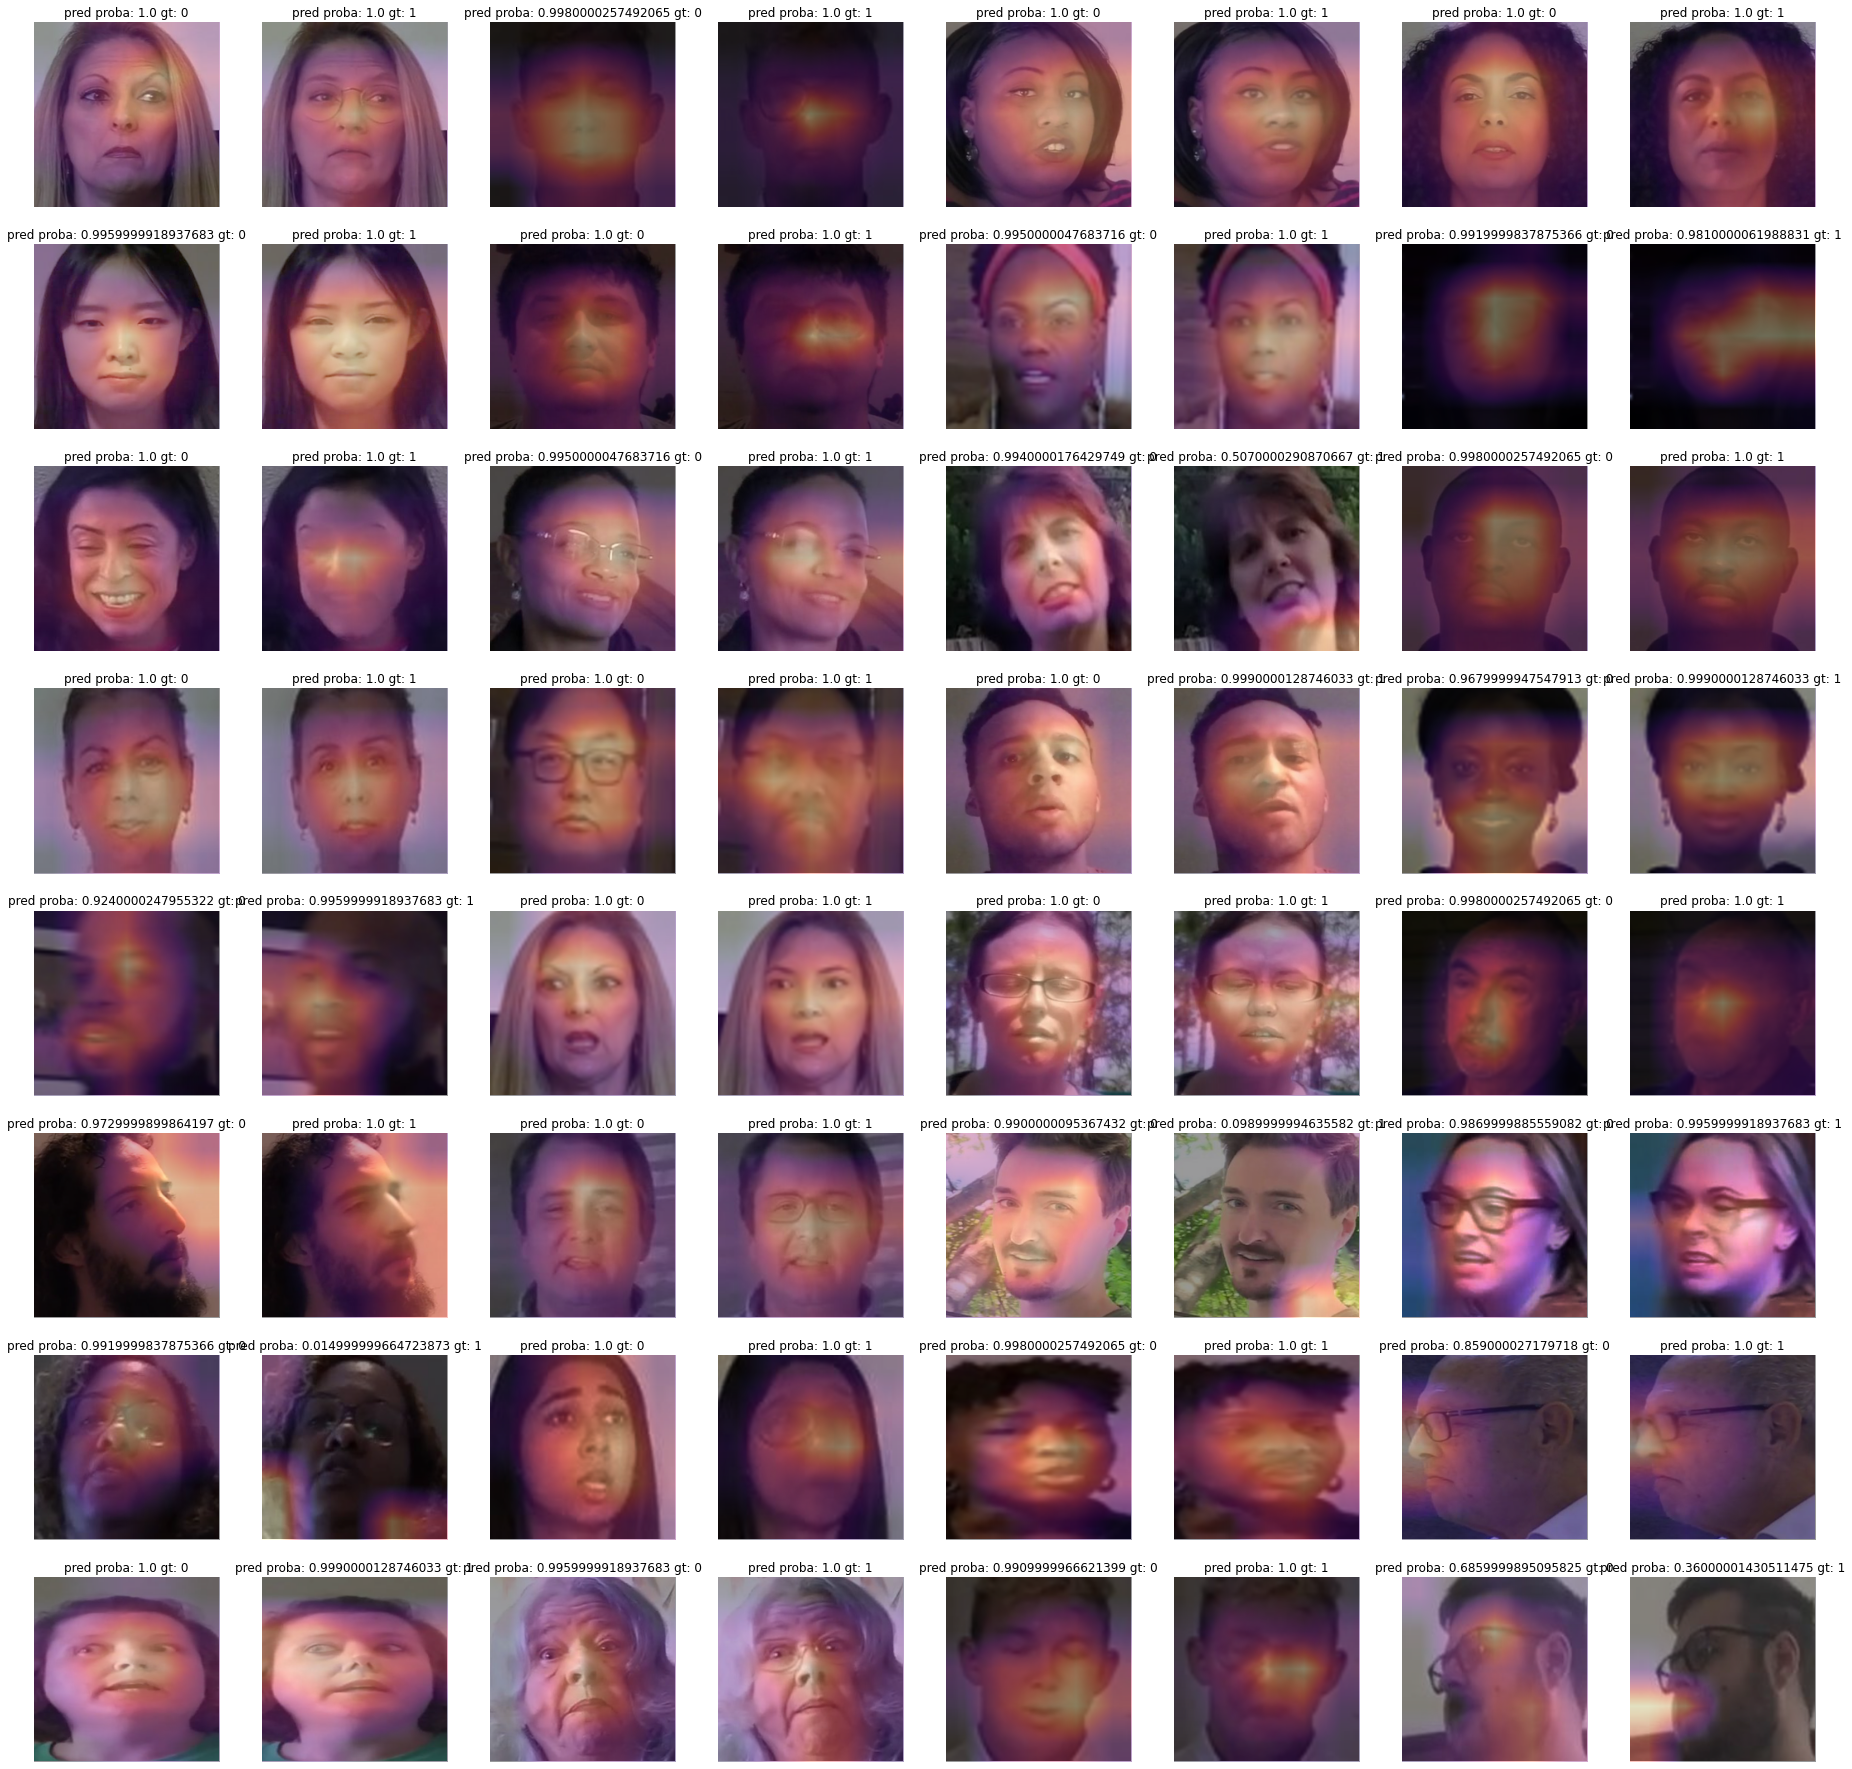

In [230]:
n = 8
axes = subplots(n,n).flatten()
for ax, t, l in zip(axes, xb[:n**2], yb[:n**2]):
    show_gradcam(m,t,l,ax=ax)

### download model

In [78]:
from IPython.display import FileLink
FileLink(learner.data.path/learner.model_dir/'multi_frame_resnet_lstm.pth')

/home/ubuntu/git/dfdc/nbs/models/multi_frame_resnet_lstm.pth

### export 

In [26]:
from nbdev.export import notebook2script
notebook2script()